In [2]:
# Import libraries
import pandas as pd
import numpy  as np
import os
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time
from tensorflow import keras
from keras.metrics import SparseCategoricalAccuracy
from keras.metrics import Recall
from sklearn.metrics import confusion_matrix
from keras import backend as K
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Add
from keras.models import load_model
import keras_tuner as kt


## Pre-processing data

In [3]:
# Merge sensor data with labels

audio_original = pd.read_csv("../feature_extraction/audio_features.csv")
lexical_original = pd.read_csv("../feature_extraction/bertembeddings.csv")

emotion_path = '../data/VAM_Audio/docu/transcription.xls'
emotions_all = pd.read_excel(emotion_path,usecols="A,C:F",skiprows=1,dtype={'File name': 'string', 'Transcription': 'string'})
emotion_labels = emotions_all[['File name','Valence','Activation']].rename(columns={"Activation":"Arousal_binary", "Valence":"Valence_binary"})

# Binarize emotion labels
emotion_labels['Valence_binary'] = emotion_labels['Valence_binary'].apply(lambda x:0 if x < 0 else 1)
emotion_labels['Arousal_binary'] = emotion_labels['Arousal_binary'].apply(lambda x:0 if x < 0 else 1)

# Convert to PID
audio_original['PID'] = audio_original['file'].str[-9:-7].astype('int')
audio_original['File name'] = audio_original['file'].str[-13:-4]
lexical_original['PID'] = lexical_original['File name'].str[-5:-3].astype('int')
emotion_labels['PID'] = emotion_labels['File name'].str[-5:-3].astype('int')

# # Merge audio lexical
audio_lexical_merge = audio_original.merge(lexical_original, on=["File name","PID"])

audio_lexical_merge_arousal = audio_lexical_merge.merge(emotion_labels[["File name","Arousal_binary"]], on="File name")
audio_lexical_merge_valence = audio_lexical_merge.merge(emotion_labels[["File name","Valence_binary"]], on="File name")



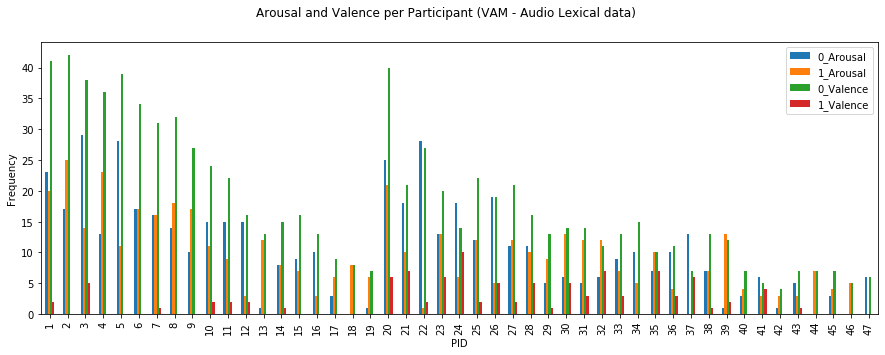

In [4]:
arousal_df = audio_lexical_merge_arousal.groupby("PID")['Arousal_binary'].value_counts().unstack()
valence_df = audio_lexical_merge_valence.groupby("PID")['Valence_binary'].value_counts().unstack()

merged_counts = arousal_df.merge(valence_df, on='PID',suffixes=('_Arousal', '_Valence')).fillna(0)

merged_counts.plot.bar(figsize=(15,5))
plt.suptitle("Arousal and Valence per Participant (VAM - Audio Lexical data)")
plt.ylabel("Frequency")
plt.savefig("VAM_AV_per_participant.png")
plt.show()


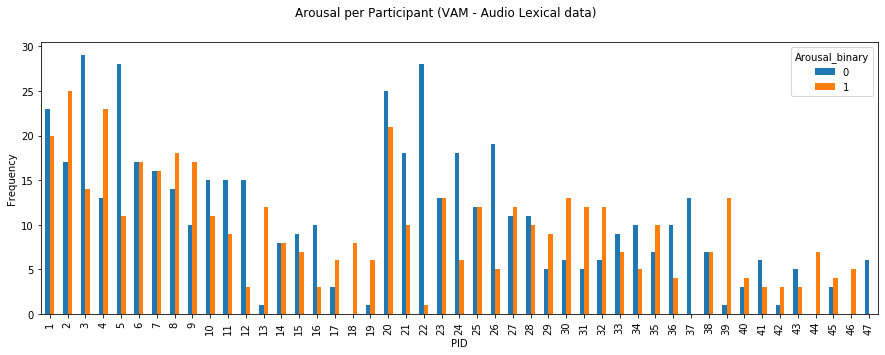

In [5]:
arousal_df = audio_lexical_merge_arousal.groupby("PID")['Arousal_binary'].value_counts().unstack().plot.bar(figsize=(15,5))
plt.suptitle("Arousal per Participant (VAM - Audio Lexical data)")
plt.ylabel("Frequency")
plt.savefig("VAM_A_per_participant.png")
plt.show()


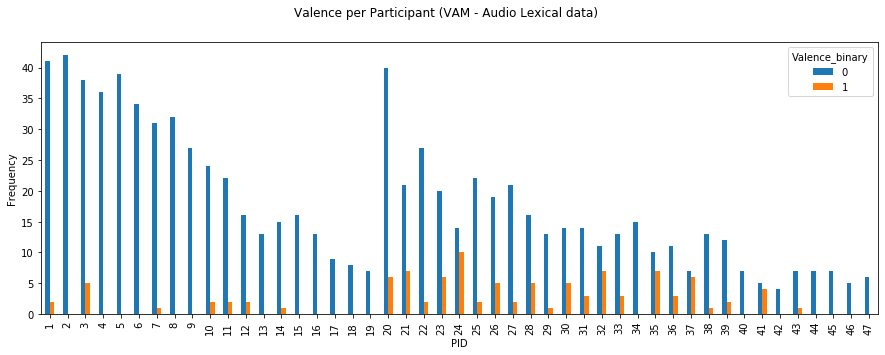

In [6]:
valence_df = audio_lexical_merge_valence.groupby("PID")['Valence_binary'].value_counts().unstack().plot.bar(figsize=(15,5))
plt.suptitle("Valence per Participant (VAM - Audio Lexical data)")
plt.ylabel("Frequency")
plt.savefig("VAM_V_per_participant.png")
plt.show()


In [7]:
# Removing participants with 100% imbalance in arousal

list_of_remove_participants_arousal = [18, 37, 44, 46, 47]
for pid in list_of_remove_participants_arousal:
    audio_lexical_merge_arousal = audio_lexical_merge_arousal[audio_lexical_merge_arousal.PID != pid]
    
# Define groups
audio_lexical_merge_arousal_groups = audio_lexical_merge_arousal['PID'].reset_index(drop=True)

In [8]:
# Removing participants with 100% imbalance in valence

list_of_remove_participants_valence = [2, 4, 5, 6, 8, 9, 13, 15, 16, 17, 18, 19, 34, 40, 44, 45, 46, 47]
for pid in list_of_remove_participants_valence:
    audio_lexical_merge_valence = audio_lexical_merge_valence[audio_lexical_merge_valence.PID != pid]
    
# Define groups
audio_lexical_merge_valence_groups = audio_lexical_merge_valence['PID'].reset_index(drop=True)

In [9]:
# Shapes to check if merge done properly and samples left after removing participants in each emotion dimension

print(audio_original.shape) # Samples coming from audio
print(lexical_original.shape) # Samples coming from lexical (transcripts)
print(audio_lexical_merge.shape) # Samples after merging two modalities
print(audio_lexical_merge_arousal.shape) # Samples after removing participants with 100% class imbalance in arousal
print(audio_lexical_merge_valence.shape) # Samples after removing participants with 100% class imbalance in valence

(947, 93)
(947, 770)
(947, 861)
(908, 862)
(624, 862)


# Applying ML and DNN 

## Early fusion: Arousal

In [10]:
# Splitting in X and y and validation

alA_x_all = audio_lexical_merge_arousal.drop(columns=(["file", "start", "end","Arousal_binary","PID","File name"]))
alA_y_all = audio_lexical_merge_arousal["Arousal_binary"]

# Get stratified split to make validation set
cv = StratifiedGroupKFold(n_splits=10, random_state=1, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(alA_x_all, alA_y_all, audio_lexical_merge_arousal_groups)):
    if folds == 1: 
        alA_x = alA_x_all.iloc[train_idxs]
        alA_y = alA_y_all.iloc[train_idxs]
        alA_x_val = alA_x_all.iloc[test_idxs]
        alA_y_val = alA_y_all.iloc[test_idxs]
        
        train_test_groups_arousal = audio_lexical_merge_arousal_groups.iloc[train_idxs]
        val_groups_arousal = audio_lexical_merge_arousal_groups.iloc[test_idxs]
        
        train_test_groups_arousal_unique = np.unique(audio_lexical_merge_arousal_groups.iloc[train_idxs])
        val_groups_arousal_unique = np.unique(audio_lexical_merge_arousal_groups.iloc[test_idxs])
        
print(alA_x.shape)
print(alA_x_val.shape)
print("Train test groups: ", train_test_groups_arousal_unique)
print("Validation groups: ", val_groups_arousal_unique)

(816, 856)
(92, 856)
Train test groups:  [ 1  3  4  5  6  7  8  9 10 11 12 14 15 16 17 19 20 21 22 23 24 25 26 27
 29 30 31 32 34 35 36 38 39 40 41 42 43 45]
Validation groups:  [ 2 13 28 33]


In [12]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(alA_x, alA_y, groups=train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Score: 0.7379437386969128
Best Hyperparameters: {'C': 0.01, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'linear'}


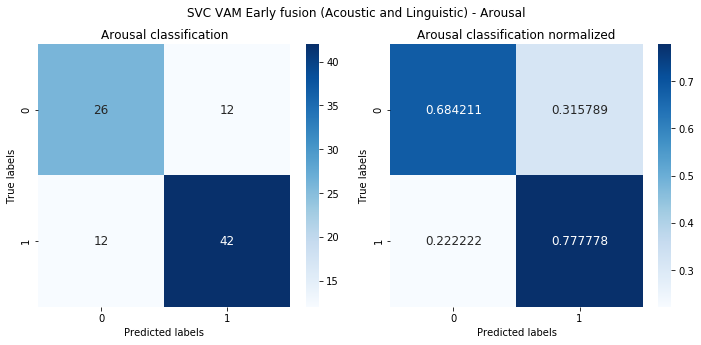

SVM validation Arousal score with best hyperparameters - Audio Lexical: 0.7309941520467836


In [11]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = alA_x
y_train = alA_y
X_test = alA_x_val
y_test = alA_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=0.01,class_weight="balanced", degree=2, kernel="linear")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC VAM Early fusion (Acoustic and Linguistic) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters - Audio Lexical:", uar)

In [12]:
# Creating a train and test set for hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=8, random_state=12, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(alA_x, alA_y, train_test_groups_arousal)):
    if folds == 1: 
        alA_x_train = alA_x_all.iloc[train_idxs]
        alA_y_train = alA_y_all.iloc[train_idxs]
        alA_x_test = alA_x_all.iloc[test_idxs]
        alA_y_test = alA_y_all.iloc[test_idxs]
        
        alA_x_train_groups = np.unique(train_test_groups_arousal.iloc[train_idxs])
        alA_x_test_groups = np.unique(train_test_groups_arousal.iloc[test_idxs])
        
print("Training groups: ", alA_x_train_groups)
print("Testing groups: ", alA_x_test_groups)

Training groups:  [ 3  4  5  6  7  8  9 10 12 14 16 17 19 20 21 22 23 24 25 27 29 30 31 32
 34 35 36 38 39 40 41 42 43 45]
Testing groups:  [ 1 11 15 26]


In [13]:
# Defining UAR metric

def UAR_metric(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    uar = ((tp / (tp+fn+K.epsilon())) + (tn /(tn+fp+K.epsilon()))) /2
    return uar

In [60]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=856, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Tune the number of units in the first Dense layer
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='VAM_AudioLexicalMerge',
                     project_name='Trial1Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(alA_x_train, alA_y_train, epochs=100, validation_data=(alA_x_test, alA_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 03s]
val_UAR_metric: 0.7153186202049255

Best val_UAR_metric So Far: 0.7224615216255188
Total elapsed time: 00h 03m 27s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 464 
 Second layer: 496 
 Third layer: 400 
 
 Dropout 1: 0.3 
 Dropout 2: 0.3 
 Dropout 3: 0.5 
 and the optimal learning rate for the optimizer
is 0.0001.



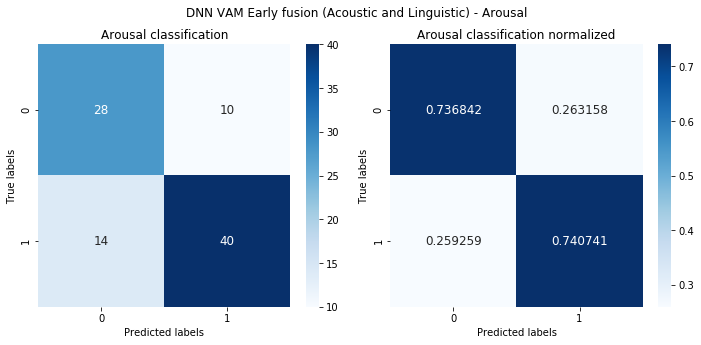

DNN validation score arousal with best hyperparameters -- Audio Lexical 0.7387914230019492


In [47]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = alA_x
y_train = alA_y
X_test = alA_x_val
y_test = alA_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Fitting DNN
model = Sequential()
model.add(Dense(464, input_dim=856, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(496, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(400, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)


# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

############# Remove #####################
# # Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(464, input_dim=856, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(Dense(496, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(Dense(400, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=0.0001)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)
############# Remove #####################

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN VAM Early fusion (Acoustic and Linguistic) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score arousal with best hyperparameters -- Audio Lexical", uar)
# print("DNN validation score arousal with best hyperparameters -- Audio Lexical", np.mean(uar_average), np.std(uar_average))

In [48]:
## Saving model for transfer learning

model.save('VAM_audio_lexical_earlyfusion_arousal.h5')

## Early fusion: Valence

In [15]:
# Splitting in X and y and validation

alV_x_all = audio_lexical_merge_valence.drop(columns=(["file", "start", "end","Valence_binary","PID","File name"]))
alV_y_all = audio_lexical_merge_valence["Valence_binary"]

# Get stratified split to make validation set
cv = StratifiedGroupKFold(n_splits=8, random_state=4, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(alV_x_all, alV_y_all, audio_lexical_merge_valence_groups)):
    if folds == 1: 
        alV_x = alV_x_all.iloc[train_idxs]
        alV_y = alV_y_all.iloc[train_idxs]
        alV_x_val = alV_x_all.iloc[test_idxs]
        alV_y_val = alV_y_all.iloc[test_idxs]
        
        train_test_groups_valence = audio_lexical_merge_valence_groups.iloc[train_idxs]
        val_groups_valence = audio_lexical_merge_valence_groups.iloc[test_idxs]
        
        train_test_groups_valence_unique = np.unique(audio_lexical_merge_valence_groups.iloc[train_idxs])
        val_groups_valence_unique = np.unique(audio_lexical_merge_valence_groups.iloc[test_idxs])
        
print(alV_x.shape)
print(alV_x_val.shape)
print("Train test groups: ", train_test_groups_valence_unique)
print("Validation groups: ", val_groups_valence_unique)

(562, 856)
(62, 856)
Train test groups:  [ 1  3  7 10 11 12 14 20 22 23 24 25 26 27 29 30 31 32 33 35 36 38 39 41
 42 43]
Validation groups:  [21 28 37]


In [115]:
# Hyperparameter tuning

start_time = time.time()
# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=10, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(alV_x, alV_y, groups=train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

end_time = time.time()
print("Time taken: ", end_time - start_time) 

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Best Score: 0.5858422494460969
Best Hyperparameters: {'C': 10, 'class_weight': 'balanced', 'degree': 4, 'kernel': 'poly'}
Time taken:  547.4706752300262


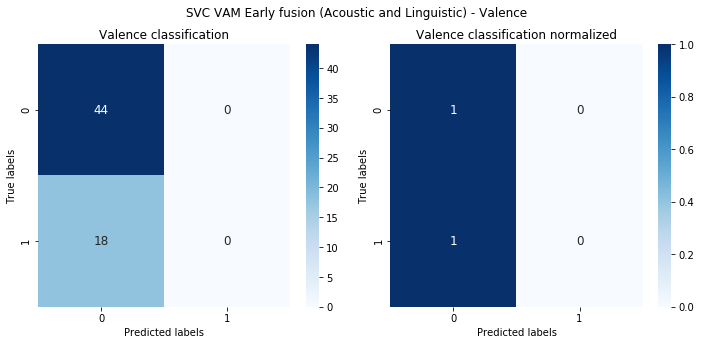

VAM SVM validation score valence with best hyperparameters -- Audio Lexical: 0.5


In [18]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = alV_x
y_train = alV_y
X_test = alV_x_val
y_test = alV_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=10,class_weight="balanced", degree=4, kernel="poly")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)
uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC VAM Early fusion (Acoustic and Linguistic) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("VAM SVM validation score valence with best hyperparameters -- Audio Lexical:", uar)

In [127]:
# Creating a train and test set for hyperparameter tuning

cv = StratifiedGroupKFold(n_splits=6, random_state=12, shuffle=True)
for folds, (train_idxs, test_idxs) in enumerate(cv.split(alV_x, alV_y, train_test_groups_valence)):
    if folds == 1: 
        alV_x_train = alV_x_all.iloc[train_idxs]
        alV_y_train = alV_y_all.iloc[train_idxs]
        alV_x_test = alV_x_all.iloc[test_idxs]
        alV_y_test = alV_y_all.iloc[test_idxs]
        
        alV_x_train_groups = np.unique(train_test_groups_valence.iloc[train_idxs])
        alV_x_test_groups = np.unique(train_test_groups_valence.iloc[test_idxs])
        
print("Training groups: ", alV_x_train_groups)
print("Testing groups: ", alV_x_test_groups)

Training groups:  [ 1  7 10 12 14 20 22 23 24 26 27 29 30 31 32 33 35 36 38 39 41 43]
Testing groups:  [ 3 11 25 42]


In [70]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=856, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='VAM_AudioLexicalMerge',
                     project_name='Trial2Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(alV_x_train, alV_y_train, epochs=100, validation_data=(alV_x_test, alV_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 02s]
val_UAR_metric: 0.6262452602386475

Best val_UAR_metric So Far: 0.6262452602386475
Total elapsed time: 00h 02m 57s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 64 
 Second layer: 208 
 Third layer: 32 
 
 Dropout 1: 0.3 
 Dropout 2: 0.1 
 Dropout 3: 0.4 
 and the optimal learning rate for the optimizer
is 1e-05.



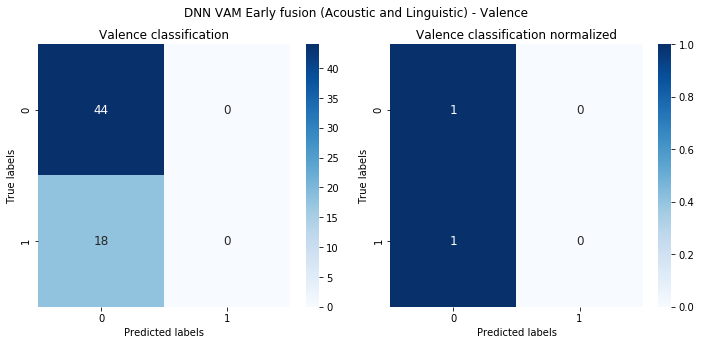

DNN validation score with best hyperparameters for valence: 0.5


In [19]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = alV_x
y_train = alV_y
X_test = alV_x_val
y_test = alV_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Fitting DNN
model = Sequential()
model.add(Dense(224, input_dim=856, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(160, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(384, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
# stop_early = keras.callbacks.EarlyStopping(monitor='UAR_metric', patience=10)
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

############# Remove #####################
# Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(64, input_dim=856, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(Dense(208, activation="relu"))
#     model.add(Dropout(0.1))
#     model.add(Dense(32, activation="relu"))
#     model.add(Dropout(0.4))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=1e-5)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     # stop_early = keras.callbacks.EarlyStopping(monitor='UAR_metric', patience=10)
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN VAM Early fusion (Acoustic and Linguistic) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score with best hyperparameters for valence:", uar)
# print("DNN validation score with best hyperparameters for valence:", np.mean(uar_average), np.std(uar_average))

In [20]:
## Saving model for transfer learning
model.save('VAM_audio_lexical_earlyfusion_valence.h5')

### Late Fusion pre-processing

In [21]:
audio_unimodal_features = audio_original.copy()
lexical_unimodal_features = lexical_original.copy()

audio_unimodal_labels_merge_arousal = audio_unimodal_features.merge(emotion_labels[["File name","Arousal_binary"]], on="File name")
lexical_unimodal_labels_merge_arousal = lexical_unimodal_features.merge(emotion_labels[["File name","Arousal_binary"]], on="File name")

audio_unimodal_labels_merge_valence = audio_unimodal_features.merge(emotion_labels[["File name","Valence_binary"]], on="File name")
lexical_unimodal_labels_merge_valence = lexical_unimodal_features.merge(emotion_labels[["File name","Valence_binary"]], on="File name")

In [22]:
# Removing participants with 100% imbalance in arousal

# Audio arousal
list_of_remove_participants_arousal = [18, 37, 44, 46, 47]
for pid in list_of_remove_participants_arousal:
    audio_unimodal_labels_merge_arousal = audio_unimodal_labels_merge_arousal[audio_unimodal_labels_merge_arousal.PID != pid]
# Define groups
audio_arousal_groups = audio_unimodal_labels_merge_arousal['PID']#.reset_index(drop=True)


# Lexical arousal
list_of_remove_participants_arousal = [18, 37, 44, 46, 47]
for pid in list_of_remove_participants_arousal:
    lexical_unimodal_labels_merge_arousal = lexical_unimodal_labels_merge_arousal[lexical_unimodal_labels_merge_arousal.PID != pid]

# Define groups
lexical_arousal_groups = lexical_unimodal_labels_merge_arousal['PID']#.reset_index(drop=True)

In [23]:
# Removing participants with 100% imbalance in valence

# Audio valence
list_of_remove_participants_valence = [2, 4, 5, 6, 8, 9, 13, 15, 16, 17, 18, 19, 34, 40, 44, 45, 46, 47]
for pid in list_of_remove_participants_valence:
    audio_unimodal_labels_merge_valence = audio_unimodal_labels_merge_valence[audio_unimodal_labels_merge_valence.PID != pid]

# Define groups
audio_valence_groups = audio_unimodal_labels_merge_valence['PID']#.reset_index(drop=True)


# Lexical valence
list_of_remove_participants_valence = [2, 4, 5, 6, 8, 9, 13, 15, 16, 17, 18, 19, 34, 40, 44, 45, 46, 47]
for pid in list_of_remove_participants_valence:
    lexical_unimodal_labels_merge_valence = lexical_unimodal_labels_merge_valence[lexical_unimodal_labels_merge_valence.PID != pid]

# Define groups
lexical_valence_groups = lexical_unimodal_labels_merge_valence['PID']#.reset_index(drop=True)

In [24]:
# Checking if correct number of samples are there are removal

print(audio_unimodal_labels_merge_arousal.shape)
print(lexical_unimodal_labels_merge_arousal.shape)
print(audio_unimodal_labels_merge_valence.shape)
print(lexical_unimodal_labels_merge_valence.shape)

(908, 94)
(908, 771)
(624, 94)
(624, 771)


In [ ]:
# audio_arousal_x_all = audio_unimodal_labels_merge_arousal.drop(columns=(["Name","Arousal_binary","PID","ID"]))
# audio_arousal_y_all = audio_unimodal_labels_merge_arousal["Arousal_binary"]

# # Get stratified split to make validation set
# cv = StratifiedGroupKFold(n_splits=5, random_state=1, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(audio_arousal_x_all, audio_arousal_y_all, audio_arousal_groups)):
#     if folds == 1: 
#         audio_arousal_x = audio_arousal_x_all.iloc[train_idxs]
#         audio_arousal_y = audio_arousal_y_all.iloc[train_idxs]
#         audio_arousal_x_val = audio_arousal_x_all.iloc[test_idxs]
#         audio_arousal_y_val = audio_arousal_y_all.iloc[test_idxs]
        
#         audio_train_test_groups_arousal = audio_arousal_groups.iloc[train_idxs]
#         audio_val_groups_arousal = audio_arousal_groups.iloc[test_idxs]
        
#         audio_train_test_groups_arousal_unique = np.unique(audio_arousal_groups.iloc[train_idxs])
#         audio_val_groups_arousal_unique = np.unique(audio_arousal_groups.iloc[test_idxs])
        
# print(audio_arousal_x.shape)
# print(audio_arousal_x_val.shape)
# print("Train test groups: ", audio_train_test_groups_arousal_unique)
# print("Validation groups: ", audio_val_groups_arousal_unique)


In [25]:
audio_arousal_x_all = audio_unimodal_labels_merge_arousal.drop(columns=(["file", "start", "end","Arousal_binary","PID","File name"]))
audio_arousal_y_all = audio_unimodal_labels_merge_arousal["Arousal_binary"]

# Giving the same training and validation groups as in early fusion for arousal audio lexical
train_idxs = audio_unimodal_labels_merge_arousal.loc[~audio_unimodal_labels_merge_arousal['PID'].isin([2, 13, 28, 33])].index.to_list()
test_idxs = audio_unimodal_labels_merge_arousal.loc[audio_unimodal_labels_merge_arousal['PID'].isin([2, 13, 28, 33])].index

audio_arousal_x = audio_arousal_x_all.loc[train_idxs]
audio_arousal_y = audio_arousal_y_all.loc[train_idxs]
audio_arousal_x_val = audio_arousal_x_all.loc[test_idxs]
audio_arousal_y_val = audio_arousal_y_all.loc[test_idxs]

audio_train_test_groups_arousal = audio_arousal_groups.loc[train_idxs]
audio_val_groups_arousal = audio_arousal_groups.loc[test_idxs]

audio_train_test_groups_arousal_unique = np.unique(audio_arousal_groups.loc[train_idxs])
audio_val_groups_arousal_unique = np.unique(audio_arousal_groups.loc[test_idxs])
        
print(audio_arousal_x.shape)
print(audio_arousal_x_val.shape)
print("Train test groups: ", audio_train_test_groups_arousal_unique)
print("Validation groups: ", audio_val_groups_arousal_unique) # [ 2 13 28 33]

(816, 88)
(92, 88)
Train test groups:  [ 1  3  4  5  6  7  8  9 10 11 12 14 15 16 17 19 20 21 22 23 24 25 26 27
 29 30 31 32 34 35 36 38 39 40 41 42 43 45]
Validation groups:  [ 2 13 28 33]


In [ ]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=5, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(audio_arousal_x, audio_arousal_y, groups=audio_train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


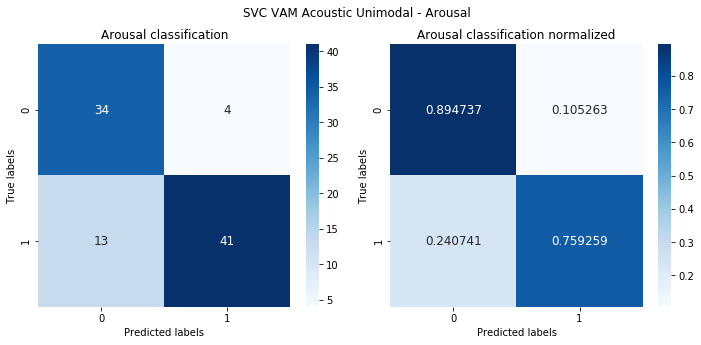

SVM validation Arousal score with best hyperparameters - Audio Model: 0.8269980506822612


In [27]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = audio_arousal_x
y_train = audio_arousal_y
X_test = audio_arousal_x_val
y_test = audio_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=10,class_weight=None, degree=2, kernel="linear")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC VAM Acoustic Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters - Audio Model:", uar)

In [82]:
# # Creating a train and test set for hyperparameter tuning

# cv = StratifiedGroupKFold(n_splits=5, random_state=12, shuffle=True)
# for folds, (train_idxs, test_idxs) in enumerate(cv.split(audio_arousal_x, audio_arousal_y, audio_train_test_groups_arousal)):
#     if folds == 1: 
#         audio_arousal_x_train = audio_arousal_x_all.iloc[train_idxs]
#         audio_arousal_y_train = audio_arousal_y_all.iloc[train_idxs]
#         audio_arousal_x_test = audio_arousal_x_all.iloc[test_idxs]
#         audio_arousal_y_test = audio_arousal_y_all.iloc[test_idxs]
        
#         audio_arousal_x_train_groups = np.unique(audio_train_test_groups_arousal.iloc[train_idxs])
#         audio_arousal_x_test_groups = np.unique(audio_train_test_groups_arousal.iloc[test_idxs])
        
# print("Training groups: ", audio_arousal_x_train_groups)
# print("Testing groups: ", audio_arousal_x_test_groups) #[ 1 11 15 26]

In [28]:

# Giving the same training and validation groups as in early fusion for arousal audio lexical
train_idxs = audio_unimodal_labels_merge_arousal.loc[~audio_unimodal_labels_merge_arousal['PID'].isin([1, 11, 15, 26])].index.to_list()
test_idxs = audio_unimodal_labels_merge_arousal.loc[audio_unimodal_labels_merge_arousal['PID'].isin([1, 11, 15, 26])].index

audio_arousal_x_train = audio_arousal_x_all.loc[train_idxs]
audio_arousal_y_train = audio_arousal_y_all.loc[train_idxs]
audio_arousal_x_test = audio_arousal_x_all.loc[test_idxs]
audio_arousal_y_test = audio_arousal_y_all.loc[test_idxs]

audio_arousal_x_train_groups = np.unique(audio_arousal_groups.loc[train_idxs])
audio_arousal_x_test_groups = np.unique(audio_arousal_groups.loc[test_idxs])
        
print("Training groups: ", audio_arousal_x_train_groups)
print("Testing groups: ", audio_arousal_x_test_groups)#[ 1 11 15 26]

Training groups:  [ 2  3  4  5  6  7  8  9 10 12 13 14 16 17 19 20 21 22 23 24 25 27 28 29
 30 31 32 33 34 35 36 38 39 40 41 42 43 45]
Testing groups:  [ 1 11 15 26]


In [84]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=88, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='VAM_AudioLexicalUnimodal',
                     project_name='Trial1_Audio_Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(audio_arousal_x_train, audio_arousal_y_train, epochs=100, validation_data=(audio_arousal_x_test, audio_arousal_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 08s]
val_UAR_metric: 0.5798106789588928

Best val_UAR_metric So Far: 0.7258865833282471
Total elapsed time: 00h 07m 46s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
 First layer: 48 
 Second layer: 512 
 Third layer: 512 
 
 Dropout 1: 0.5 
 Dropout 2: 0.0 
 Dropout 3: 0.3 
 and the optimal learning rate for the optimizer
is 0.001.



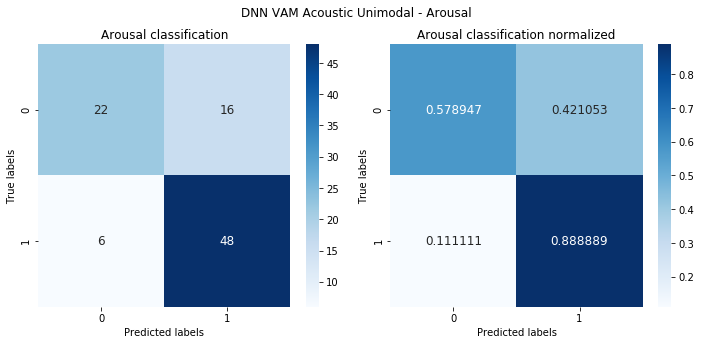

DNN validation score arousal with best hyperparameters -- Audio 0.7339181286549707


In [63]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = audio_arousal_x
y_train = audio_arousal_y
X_test = audio_arousal_x_val
y_test = audio_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Fitting DNN
model = Sequential()
model.add(Dense(48, input_dim=88, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

############# Remove #####################
# Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(48, input_dim=88, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(512, activation="relu"))
#     model.add(Dropout(0.0))
#     model.add(Dense(512, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=0.001)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)
# ############# Remove #####################

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN VAM Acoustic Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score arousal with best hyperparameters -- Audio", uar)
# print("DNN validation score arousal with best hyperparameters -- Audio Model", np.mean(uar_average), np.std(uar_average))

### Late Fusion: Valence -- Audio

In [31]:
audio_valence_x_all = audio_unimodal_labels_merge_valence.drop(columns=(["file", "start", "end","Valence_binary","PID","File name"]))
audio_valence_y_all = audio_unimodal_labels_merge_valence["Valence_binary"]

# Giving the same training and validation groups as in early fusion for valence audio lexical
train_idxs = audio_unimodal_labels_merge_valence.loc[~audio_unimodal_labels_merge_valence['PID'].isin([21, 28, 37])].index.to_list()
test_idxs = audio_unimodal_labels_merge_valence.loc[audio_unimodal_labels_merge_valence['PID'].isin([21, 28, 37])].index

audio_valence_x = audio_valence_x_all.loc[train_idxs]
audio_valence_y = audio_valence_y_all.loc[train_idxs]
audio_valence_x_val = audio_valence_x_all.loc[test_idxs]
audio_valence_y_val = audio_valence_y_all.loc[test_idxs]

audio_train_test_groups_valence = audio_valence_groups.loc[train_idxs]
audio_val_groups_valence = audio_valence_groups.loc[test_idxs]

audio_train_test_groups_valence_unique = np.unique(audio_valence_groups.loc[train_idxs])
audio_val_groups_valence_unique = np.unique(audio_valence_groups.loc[test_idxs])
        
print(audio_valence_x.shape)
print(audio_valence_x_val.shape)
print("Train test groups: ", audio_train_test_groups_valence_unique)
print("Validation groups: ", audio_val_groups_valence_unique) # [21 28 37]

(562, 88)
(62, 88)
Train test groups:  [ 1  3  7 10 11 12 14 20 22 23 24 25 26 27 29 30 31 32 33 35 36 38 39 41
 42 43]
Validation groups:  [21 28 37]


In [ ]:
# Hyperparameter tuning SVM

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=4, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(audio_valence_x, audio_valence_y, groups=audio_train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


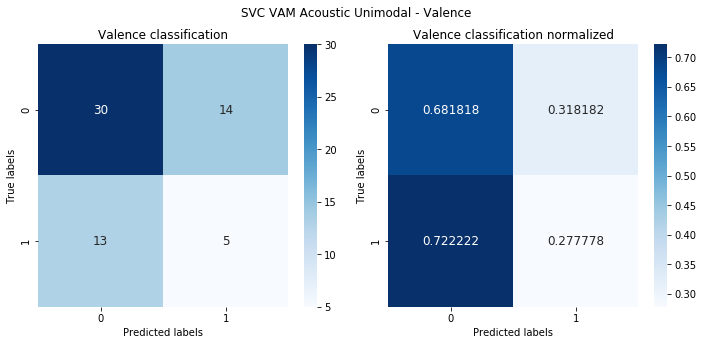

SVM validation score valence with best hyperparameters -- Audio Unimodal: 0.4797979797979798


In [32]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = audio_valence_x
y_train = audio_valence_y
X_test = audio_valence_x_val
y_test = audio_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=1,class_weight="balanced", degree=2, kernel="sigmoid")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)
uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC VAM Acoustic Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation score valence with best hyperparameters -- Audio Unimodal:", uar)

In [33]:
# Creating a train and test set for hyperparameter tuning

# Giving the same training and validation groups as in early fusion for valence audio lexical
train_idxs = audio_unimodal_labels_merge_valence.loc[~audio_unimodal_labels_merge_valence['PID'].isin([3, 11, 25, 42])].index.to_list()
test_idxs = audio_unimodal_labels_merge_valence.loc[audio_unimodal_labels_merge_valence['PID'].isin([3, 11, 25, 42])].index


audio_valence_x_train = audio_valence_x_all.loc[train_idxs]
audio_valence_y_train = audio_valence_y_all.loc[train_idxs]
audio_valence_x_test = audio_valence_x_all.loc[test_idxs]
audio_valence_y_test = audio_valence_y_all.loc[test_idxs]

audio_valence_x_train_groups_numbers = audio_valence_groups.loc[train_idxs]
audio_valence_x_test_groups_numbers = audio_valence_groups.loc[test_idxs]

audio_valence_x_train_groups = np.unique(audio_valence_groups.loc[train_idxs])
audio_valence_x_test_groups = np.unique(audio_valence_groups.loc[test_idxs])
        
print("Training groups: ", audio_valence_x_train_groups)
print("Testing groups: ", audio_valence_x_test_groups) #[ 3 11 25 42]
print("Training size", audio_valence_x_train_groups_numbers.shape)
print("Testing size", audio_valence_x_test_groups_numbers.shape)

Training groups:  [ 1  7 10 12 14 20 21 22 23 24 26 27 28 29 30 31 32 33 35 36 37 38 39 41
 43]
Testing groups:  [ 3 11 25 42]
Training size (529,)
Testing size (95,)


In [94]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=88, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='VAM_AudioLexicalUnimodal',
                     project_name='Trial1_Audio_Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(audio_valence_x_train, audio_valence_y_train, epochs=100, validation_data=(audio_valence_x_test, audio_valence_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 04s]
val_UAR_metric: 0.5

Best val_UAR_metric So Far: 0.5729337930679321
Total elapsed time: 00h 07m 16s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. 
 First layer: 336 
 Second layer: 48 
 Third layer: 144 
 
 Dropout 1: 0.1 
 Dropout 2: 0.4 
 Dropout 3: 0.1 
 and the optimal learning rate for the optimizer
is 0.01.



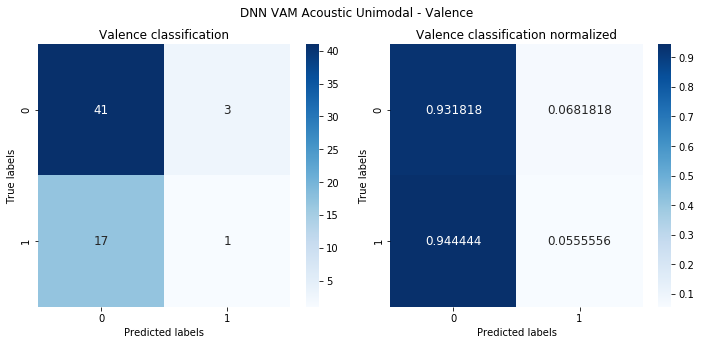

DNN validation score valence with best hyperparameters -- Audio 0.4936868686868687


In [60]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = audio_valence_x
y_train = audio_valence_y
X_test = audio_valence_x_val
y_test = audio_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Fitting DNN
model = Sequential()
model.add(Dense(336, input_dim=88, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(48, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(144, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

############# Remove #####################
# # Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(336, input_dim=88, activation="relu"))
#     model.add(Dropout(0.1))
#     model.add(Dense(48, activation="relu"))
#     model.add(Dropout(0.4))
#     model.add(Dense(144, activation="relu"))
#     model.add(Dropout(0.1))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=0.01)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)
# ############# Remove #####################

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN VAM Acoustic Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score valence with best hyperparameters -- Audio", uar)
# print("DNN validation score valence with best hyperparameters -- Audio Model", np.mean(uar_average), np.std(uar_average))

### Late Fusion: Arousal -- Lexical

In [38]:
lexical_arousal_x_all = lexical_unimodal_labels_merge_arousal.drop(columns=(["Arousal_binary","PID","File name"]))
lexical_arousal_y_all = lexical_unimodal_labels_merge_arousal["Arousal_binary"]

# Giving the same training and validation groups as in early fusion for arousal lexical lexical
train_idxs = lexical_unimodal_labels_merge_arousal.loc[~lexical_unimodal_labels_merge_arousal['PID'].isin([2, 13, 28, 33])].index.to_list()
test_idxs = lexical_unimodal_labels_merge_arousal.loc[lexical_unimodal_labels_merge_arousal['PID'].isin([2, 13, 28, 33])].index

lexical_arousal_x = lexical_arousal_x_all.loc[train_idxs]
lexical_arousal_y = lexical_arousal_y_all.loc[train_idxs]
lexical_arousal_x_val = lexical_arousal_x_all.loc[test_idxs]
lexical_arousal_y_val = lexical_arousal_y_all.loc[test_idxs]

lexical_train_test_groups_arousal = lexical_arousal_groups.loc[train_idxs]
lexical_val_groups_arousal = lexical_arousal_groups.loc[test_idxs]

lexical_train_test_groups_arousal_unique = np.unique(lexical_arousal_groups.loc[train_idxs])
lexical_val_groups_arousal_unique = np.unique(lexical_arousal_groups.loc[test_idxs])
        
print(lexical_arousal_x.shape)
print(lexical_arousal_x_val.shape)
print("Train test groups: ", lexical_train_test_groups_arousal_unique)
print("Validation groups: ", lexical_val_groups_arousal_unique) # [ 2 13 28 33]

(816, 768)
(92, 768)
Train test groups:  [ 1  3  4  5  6  7  8  9 10 11 12 14 15 16 17 19 20 21 22 23 24 25 26 27
 29 30 31 32 34 35 36 38 39 40 41 42 43 45]
Validation groups:  [ 2 13 28 33]


In [ ]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=10, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(lexical_arousal_x, lexical_arousal_y, groups=lexical_train_test_groups_arousal)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


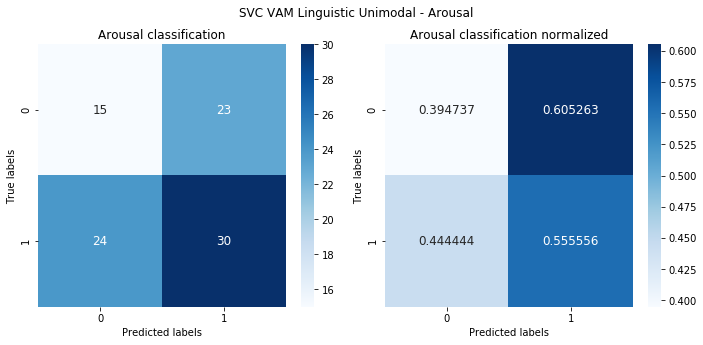

SVM validation Arousal score with best hyperparameters - Lexical Model: 0.47514619883040937


In [39]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = lexical_arousal_x
y_train = lexical_arousal_y
X_test = lexical_arousal_x_val
y_test = lexical_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=10,class_weight="balanced", degree=2, kernel="sigmoid")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)

uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC VAM Linguistic Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation Arousal score with best hyperparameters - Lexical Model:", uar)

In [40]:

# Giving the same training and validation groups as in early fusion for arousal lexical lexical
train_idxs = lexical_unimodal_labels_merge_arousal.loc[~lexical_unimodal_labels_merge_arousal['PID'].isin([1, 11, 15, 26])].index.to_list()
test_idxs = lexical_unimodal_labels_merge_arousal.loc[lexical_unimodal_labels_merge_arousal['PID'].isin([1, 11, 15, 26])].index

lexical_arousal_x_train = lexical_arousal_x_all.loc[train_idxs]
lexical_arousal_y_train = lexical_arousal_y_all.loc[train_idxs]
lexical_arousal_x_test = lexical_arousal_x_all.loc[test_idxs]
lexical_arousal_y_test = lexical_arousal_y_all.loc[test_idxs]

lexical_arousal_x_train_groups = np.unique(lexical_arousal_groups.loc[train_idxs])
lexical_arousal_x_test_groups = np.unique(lexical_arousal_groups.loc[test_idxs])
        
print("Training groups: ", lexical_arousal_x_train_groups)
print("Testing groups: ", lexical_arousal_x_test_groups)#[ 1 11 15 26]

Training groups:  [ 2  3  4  5  6  7  8  9 10 12 13 14 16 17 19 20 21 22 23 24 25 27 28 29
 30 31 32 33 34 35 36 38 39 40 41 42 43 45]
Testing groups:  [ 1 11 15 26]


In [100]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=768, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='VAM_AudioLexicalUnimodal',
                     project_name='Trial1_Lexical_Arousal')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(lexical_arousal_x_train, lexical_arousal_y_train, epochs=100, validation_data=(lexical_arousal_x_test, lexical_arousal_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 07s]
val_UAR_metric: 0.6171742081642151

Best val_UAR_metric So Far: 0.7575925588607788
Total elapsed time: 00h 08m 15s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. 
 First layer: 16 
 Second layer: 96 
 Third layer: 48 
 
 Dropout 1: 0.0 
 Dropout 2: 0.4 
 Dropout 3: 0.3 
 and the optimal learning rate for the optimizer
is 0.001.



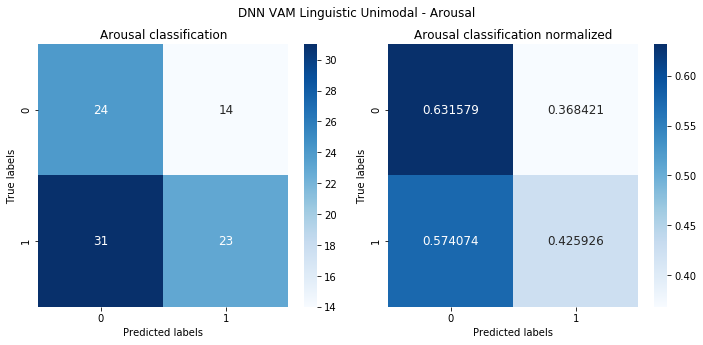

DNN validation score arousal with best hyperparameters -- Lexical Lexical 0.5287524366471734


In [42]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = lexical_arousal_x
y_train = lexical_arousal_y
X_test = lexical_arousal_x_val
y_test = lexical_arousal_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Fitting DNN
model = Sequential()
model.add(Dense(16, input_dim=768, activation="relu"))
model.add(Dropout(0.0))
model.add(Dense(96, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(48, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

############# Remove #####################
# Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(16, input_dim=768, activation="relu"))
#     model.add(Dropout(0.0))
#     model.add(Dense(96, activation="relu"))
#     model.add(Dropout(0.4))
#     model.add(Dense(48, activation="relu"))
#     model.add(Dropout(0.3))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=0.001)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)
############# Remove #####################

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN VAM Linguistic Unimodal - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score arousal with best hyperparameters -- Lexical Lexical", uar)
# print("DNN validation score arousal with best hyperparameters -- Lexical Model", np.mean(uar_average), np.std(uar_average))

### Late Fusion: Valence -- Lexical


In [43]:
lexical_valence_x_all = lexical_unimodal_labels_merge_valence.drop(columns=(["Valence_binary","PID","File name"]))
lexical_valence_y_all = lexical_unimodal_labels_merge_valence["Valence_binary"]

# Giving the same training and validation groups as in early fusion for valence lexical lexical
train_idxs = lexical_unimodal_labels_merge_valence.loc[~lexical_unimodal_labels_merge_valence['PID'].isin([21, 28, 37])].index.to_list()
test_idxs = lexical_unimodal_labels_merge_valence.loc[lexical_unimodal_labels_merge_valence['PID'].isin([21, 28, 37])].index

lexical_valence_x = lexical_valence_x_all.loc[train_idxs]
lexical_valence_y = lexical_valence_y_all.loc[train_idxs]
lexical_valence_x_val = lexical_valence_x_all.loc[test_idxs]
lexical_valence_y_val = lexical_valence_y_all.loc[test_idxs]

lexical_train_test_groups_valence = lexical_valence_groups.loc[train_idxs]
lexical_val_groups_valence = lexical_valence_groups.loc[test_idxs]

lexical_train_test_groups_valence_unique = np.unique(lexical_valence_groups.loc[train_idxs])
lexical_val_groups_valence_unique = np.unique(lexical_valence_groups.loc[test_idxs])
        
print(lexical_valence_x.shape)
print(lexical_valence_x_val.shape)
print("Train test groups: ", lexical_train_test_groups_valence_unique)
print("Validation groups: ", lexical_val_groups_valence_unique) # 21, 28, 37

(562, 768)
(62, 768)
Train test groups:  [ 1  3  7 10 11 12 14 20 22 23 24 25 26 27 29 30 31 32 33 35 36 38 39 41
 42 43]
Validation groups:  [21 28 37]


In [ ]:
# Hyperparameter tuning

# StratifiedKGroupFold
sgkf = StratifiedGroupKFold(n_splits=4, random_state=10, shuffle=True)
svm = SVC()

# Grid search
space = dict()
space['degree'] = [2,3,4]
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
space['class_weight'] = ['balanced',None]
search = GridSearchCV(svm, space, scoring='balanced_accuracy', verbose=4, n_jobs=-1, cv=sgkf)
result = search.fit(lexical_valence_x, lexical_valence_y, groups=lexical_train_test_groups_valence)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


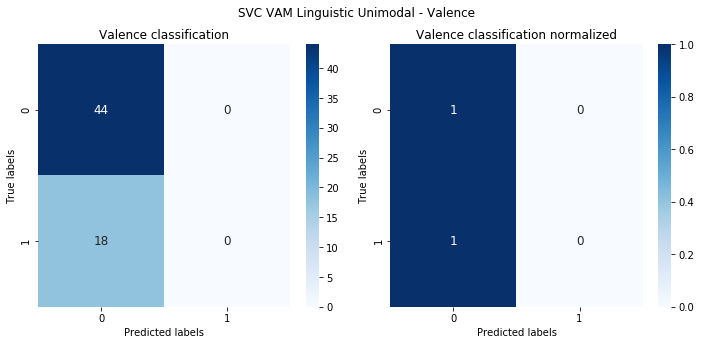

SVM validation score valence with best hyperparameters -- Lexical Unimodal: 0.5


In [44]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = lexical_valence_x
y_train = lexical_valence_y
X_test = lexical_valence_x_val
y_test = lexical_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fitting SVM training
svm = SVC(C=1e-06,class_weight=None, degree=2, kernel="linear")
svm.fit(X_train_scaled, y_train),
y_pred = svm.predict(X_test_scaled)
uar = balanced_accuracy_score(y_test,y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('SVC VAM Linguistic Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("SVM validation score valence with best hyperparameters -- Lexical Unimodal:", uar)

In [45]:

# Giving the same training and validation groups as in early fusion for valence lexical lexical
train_idxs = lexical_unimodal_labels_merge_valence.loc[~lexical_unimodal_labels_merge_valence['PID'].isin([3, 11, 25, 42])].index.to_list()
test_idxs = lexical_unimodal_labels_merge_valence.loc[lexical_unimodal_labels_merge_valence['PID'].isin([3, 11, 25, 42])].index

lexical_valence_x_train = lexical_valence_x_all.loc[train_idxs]
lexical_valence_y_train = lexical_valence_y_all.loc[train_idxs]
lexical_valence_x_test = lexical_valence_x_all.loc[test_idxs]
lexical_valence_y_test = lexical_valence_y_all.loc[test_idxs]

lexical_valence_x_train_groups = np.unique(lexical_valence_groups.loc[train_idxs])
lexical_valence_x_test_groups = np.unique(lexical_valence_groups.loc[test_idxs])
        
print("Training groups: ", lexical_valence_x_train_groups)
print("Testing groups: ", lexical_valence_x_test_groups)#[3, 11, 25, 42]

Training groups:  [ 1  7 10 12 14 20 21 22 23 24 26 27 28 29 30 31 32 33 35 36 37 38 39 41
 43]
Testing groups:  [ 3 11 25 42]


In [104]:
# Hyperparameter tuning

def model_builder(hp):
    model = keras.Sequential()
    hp_units = hp.Int('units', min_value=16, max_value=512, step=16)
    model.add(Dense(hp_units, input_dim=768, activation="relu"))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp1 = hp.Choice('dp1', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp1))
    
    hp_units1 = hp.Int('units1', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units, activation='relu'))
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    
    dp2 = hp.Choice('dp2', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp2))
    
    hp_units2 = hp.Int('units2', min_value=16, max_value=512, step=16)
    model.add(Dense(units=hp_units2, activation='relu'))
    
    dp3 = hp.Choice('dp3', values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(dp3))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="binary_crossentropy",
                metrics=[UAR_metric])
    return model

# Initialize the hyperparameter tuner

tuner = kt.Hyperband(model_builder,objective=kt.Objective('val_UAR_metric', direction='max'),
                     max_epochs=100,
                     factor=10,
                     directory='VAM_AudioLexicalUnimodal',
                     project_name='Trial1_Lexical_Valence')

# Stop early if validation doesn't change for 10 epochs
stop_early = keras.callbacks.EarlyStopping(monitor='val_UAR_metric', patience=10)
tuner.search(lexical_valence_x_train, lexical_valence_y_train, epochs=100, validation_data=(lexical_valence_x_test, lexical_valence_y_test), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. \n First layer: {best_hps.get('units')} \n Second layer: {best_hps.get('units1')} \n Third layer: {best_hps.get('units2')} \n \n Dropout 1: {best_hps.get('dp1')} \n Dropout 2: {best_hps.get('dp2')} \n Dropout 3: {best_hps.get('dp3')} \n and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 131 Complete [00h 00m 07s]
val_UAR_metric: 0.5766968131065369

Best val_UAR_metric So Far: 0.6351943016052246
Total elapsed time: 00h 07m 05s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



The hyperparameter search is complete. 
 First layer: 128 
 Second layer: 336 
 Third layer: 336 
 
 Dropout 1: 0.1 
 Dropout 2: 0.5 
 Dropout 3: 0.1 
 and the optimal learning rate for the optimizer
is 0.01.



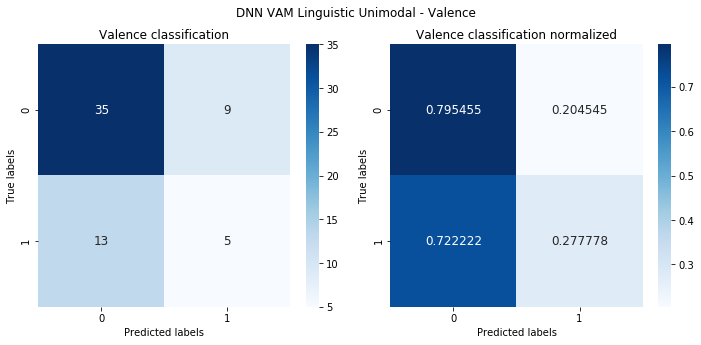

DNN validation score valence with best hyperparameters -- Lexical Model 0.5366161616161615


In [57]:
# Using the hyperparameters on validation set
# Change X_train variable names to avoid confusion later

X_train = lexical_valence_x
y_train = lexical_valence_y
X_test = lexical_valence_x_val
y_test = lexical_valence_y_val

# StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # Fitting DNN
model = Sequential()
model.add(Dense(128, input_dim=768, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(336, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(336, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

# # Prediction
y_pred = model.predict(X_test_scaled, verbose=0)
y_pred = np.rint(y_pred)
uar = balanced_accuracy_score(y_test, y_pred)

############# Remove #####################
# Fitting DNN multiple times
# uar_average = []
# for i in range(10):
#     model = Sequential()
#     model.add(Dense(128, input_dim=768, activation="relu"))
#     model.add(Dropout(0.1))
#     model.add(Dense(336, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(336, activation="relu"))
#     model.add(Dropout(0.1))
#     model.add(Dense(1, activation="sigmoid"))
#     opt = keras.optimizers.Adam(learning_rate=0.01)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
#     model.fit(X_train_scaled, y_train, epochs = 100, verbose=0)

#     # Prediction
#     y_pred = model.predict(X_test_scaled, verbose=0)
#     y_pred = np.rint(y_pred)
#     uar = balanced_accuracy_score(y_test, y_pred)
#     print(uar)
#     uar_average.append(uar)
############# Remove #####################

# Plotting the confusion matrix
cm = confusion_matrix(y_test,y_pred)
cm_normalized = confusion_matrix(y_test,y_pred, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('DNN VAM Linguistic Unimodal - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Valence classification')
axs[1].set_title('Valence classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("DNN validation score valence with best hyperparameters -- Lexical Model", uar)
# print("DNN validation score valence with best hyperparameters -- Lexical Model", np.mean(uar_average), np.std(uar_average))

### Late fusion (Audio and Lexical) - Arousal

Late fusion averaging 0.5794346978557505
Late fusion averaging prediction after converting predictions to binary 0.7012670565302144
Late fusion max of either input 0.6232943469785575
Late fusion median 0.5794346978557505


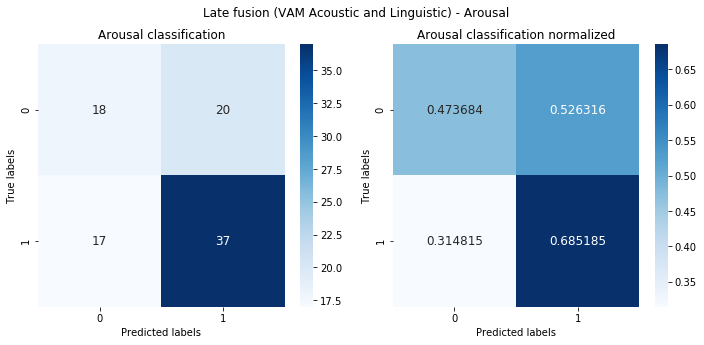

In [58]:
# Late fusion using averaging of predictions

# Find true values of arousal in validation set that is common for both

if (audio_arousal_y_val.equals(lexical_arousal_y_val)):
    audio_lexical_y_val = lexical_arousal_y_val # Should be the same as audio
else:
    raise("labels are not same")
    
# Get best DNN models and average predictions

# StandardScaler audio
scaler_audio = StandardScaler()
audio_arousal_x_scaled = scaler.fit_transform(audio_arousal_x) # train
audio_arousal_x_val_scaled = scaler.transform(audio_arousal_x_val) #test 

# Best DNN for audio arousal
audio_unimodal_arousal = Sequential()
audio_unimodal_arousal.add(Dense(48, input_dim=88, activation="relu"))
audio_unimodal_arousal.add(Dropout(0.5))
audio_unimodal_arousal.add(Dense(512, activation="relu"))
audio_unimodal_arousal.add(Dropout(0.0))
audio_unimodal_arousal.add(Dense(512, activation="relu"))
audio_unimodal_arousal.add(Dropout(0.3))
audio_unimodal_arousal.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
audio_unimodal_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
audio_unimodal_arousal.fit(audio_arousal_x_scaled, audio_arousal_y, epochs = 100, verbose=0)
## Saving model for transfer learning
audio_unimodal_arousal.save('VAM_audio_latefusion_arousal.h5')
# Prediction
audio_unimodal_arousal_y_pred = audio_unimodal_arousal.predict(audio_arousal_x_val_scaled, verbose=0)

# Best DNN for lexical arousal

# StandardScaler lexical
scaler_lexical = StandardScaler()
lexical_arousal_x_scaled = scaler.fit_transform(lexical_arousal_x) # train
lexical_arousal_x_val_scaled = scaler.transform(lexical_arousal_x_val) #test 

lexical_unimodal_arousal = Sequential()
lexical_unimodal_arousal.add(Dense(16, input_dim=768, activation="relu"))
lexical_unimodal_arousal.add(Dropout(0.0))
lexical_unimodal_arousal.add(Dense(96, activation="relu"))
lexical_unimodal_arousal.add(Dropout(0.4))
lexical_unimodal_arousal.add(Dense(48, activation="relu"))
lexical_unimodal_arousal.add(Dropout(0.3))
lexical_unimodal_arousal.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.001)
lexical_unimodal_arousal.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
lexical_unimodal_arousal.fit(lexical_arousal_x_scaled, lexical_arousal_y, epochs = 100, verbose=0)
## Saving model for transfer learning
lexical_unimodal_arousal.save('VAM_lexical_latefusion_arousal.h5')
# Prediction
lexical_unimodal_arousal_y_pred = lexical_unimodal_arousal.predict(lexical_arousal_x_val_scaled, verbose=0)

# Evaluate on 
audio_lexical_pred_merge_arousal = np.array([audio_unimodal_arousal_y_pred,lexical_unimodal_arousal_y_pred])

# Averaging prediction (baseline)
late_fusion_audio_lexical_pred_avg = np.rint(audio_lexical_pred_merge_arousal.mean(axis=0))
uar_late_fusion_audio_lexical_pred_avg = balanced_accuracy_score(audio_arousal_y_val, late_fusion_audio_lexical_pred_avg)
print("Late fusion averaging", uar_late_fusion_audio_lexical_pred_avg)

# Averaging prediction after converting predictions (baseline)
audio_lexical_pred_merge_arousal_binary = np.array([np.rint(audio_unimodal_arousal_y_pred),np.rint(lexical_unimodal_arousal_y_pred)])
late_fusion_audio_lexical_pred_avg_binary = np.rint(audio_lexical_pred_merge_arousal_binary.mean(axis=0))
uar_late_fusion_audio_lexical_pred_binary= balanced_accuracy_score(audio_arousal_y_val, late_fusion_audio_lexical_pred_avg_binary)
print("Late fusion averaging prediction after converting predictions to binary",uar_late_fusion_audio_lexical_pred_binary)

# Taking max prediction
late_fusion_audio_lexical_pred_max = np.rint(audio_lexical_pred_merge_arousal.max(axis=0))
uar_late_fusion_audio_lexical_pred_max = balanced_accuracy_score(audio_arousal_y_val, late_fusion_audio_lexical_pred_max)
print("Late fusion max of either input", uar_late_fusion_audio_lexical_pred_max)

# Taking median
late_fusion_audio_lexical_pred_median = np.rint(np.median(audio_lexical_pred_merge_arousal, axis=0))
uar_late_fusion_audio_lexical_pred_median = balanced_accuracy_score(audio_arousal_y_val, late_fusion_audio_lexical_pred_median)
print("Late fusion median", uar_late_fusion_audio_lexical_pred_median)

cm = confusion_matrix(audio_arousal_y_val,late_fusion_audio_lexical_pred_avg)
cm_normalized = confusion_matrix(audio_arousal_y_val,late_fusion_audio_lexical_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Late fusion (VAM Acoustic and Linguistic) - Arousal')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Late Fusion (Audio and Lexical) - Valence

Late fusion averaging 0.5
Late fusion averaging prediction after converting predictions to binary 0.5
Late fusion max of either input 0.5
Late fusion median 0.5


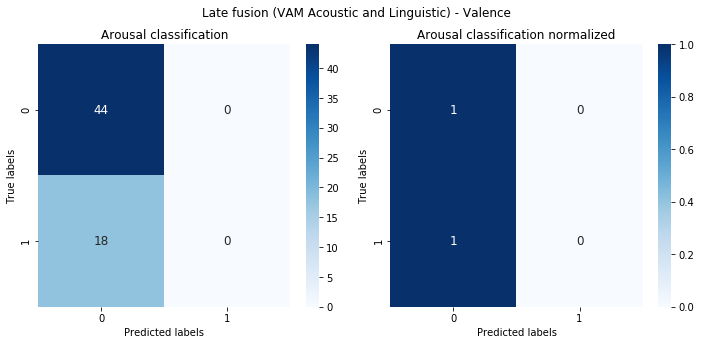

In [53]:
# Late fusion using averaging of predictions

# Find true values of valence in validation set that is common for both

if (audio_valence_y_val.equals(lexical_valence_y_val)):
    audio_lexical_y_val = lexical_valence_y_val # Should be the same as audio
else:
    raise("labels are not same")
    
# Get best DNN models and average predictions

# StandardScaler audio
scaler_audio = StandardScaler()
audio_valence_x_scaled = scaler.fit_transform(audio_valence_x) # train
audio_valence_x_val_scaled = scaler.transform(audio_valence_x_val) #test 

# Best DNN for audio valence
audio_unimodal_valence = Sequential()
audio_unimodal_valence.add(Dense(336, input_dim=88, activation="relu"))
audio_unimodal_valence.add(Dropout(0.1))
audio_unimodal_valence.add(Dense(48, activation="relu"))
audio_unimodal_valence.add(Dropout(0.4))
audio_unimodal_valence.add(Dense(144, activation="relu"))
audio_unimodal_valence.add(Dropout(0.1))
audio_unimodal_valence.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.01)
audio_unimodal_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
audio_unimodal_valence.fit(audio_valence_x_scaled, audio_valence_y, epochs = 100, verbose=0)
## Saving model for transfer learning
audio_unimodal_valence.save('VAM_audio_latefusion_valence.h5')
# Prediction
audio_unimodal_valence_y_pred = audio_unimodal_valence.predict(audio_valence_x_val_scaled, verbose=0)

# Best DNN for lexical valence

# StandardScaler lexical
scaler_lexical = StandardScaler()
lexical_valence_x_scaled = scaler.fit_transform(lexical_valence_x) # train
lexical_valence_x_val_scaled = scaler.transform(lexical_valence_x_val) #test 

lexical_unimodal_valence = Sequential()
lexical_unimodal_valence.add(Dense(128, input_dim=768, activation="relu"))
lexical_unimodal_valence.add(Dropout(0.1))
lexical_unimodal_valence.add(Dense(336, activation="relu"))
lexical_unimodal_valence.add(Dropout(0.5))
lexical_unimodal_valence.add(Dense(336, activation="relu"))
lexical_unimodal_valence.add(Dropout(0.1))
lexical_unimodal_valence.add(Dense(1, activation="sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.01)
lexical_unimodal_valence.compile(loss='binary_crossentropy', optimizer=opt, metrics=[UAR_metric])
lexical_unimodal_valence.fit(lexical_valence_x_scaled, lexical_valence_y, epochs = 100, verbose=0)
lexical_unimodal_valence.save('VAM_lexical_latefusion_valence.h5')
# Prediction
lexical_unimodal_valence_y_pred = lexical_unimodal_valence.predict(lexical_valence_x_val_scaled, verbose=0)

# Evaluate on 
audio_lexical_pred_merge_valence = np.array([audio_unimodal_valence_y_pred,lexical_unimodal_valence_y_pred])

# Averaging prediction (baseline)
late_fusion_audio_lexical_pred_avg = np.rint(audio_lexical_pred_merge_valence.mean(axis=0))
uar_late_fusion_audio_lexical_pred_avg = balanced_accuracy_score(audio_valence_y_val, late_fusion_audio_lexical_pred_avg)
print("Late fusion averaging", uar_late_fusion_audio_lexical_pred_avg)

# Averaging prediction after converting predictions (baseline)
audio_lexical_pred_merge_valence_binary = np.array([np.rint(audio_unimodal_valence_y_pred),np.rint(lexical_unimodal_valence_y_pred)])
late_fusion_audio_lexical_pred_avg_binary = np.rint(audio_lexical_pred_merge_valence_binary.mean(axis=0))
uar_late_fusion_audio_lexical_pred_binary= balanced_accuracy_score(audio_valence_y_val, late_fusion_audio_lexical_pred_avg_binary)
print("Late fusion averaging prediction after converting predictions to binary",uar_late_fusion_audio_lexical_pred_binary)

# Taking max prediction
late_fusion_audio_lexical_pred_max = np.rint(audio_lexical_pred_merge_valence.max(axis=0))
uar_late_fusion_audio_lexical_pred_max = balanced_accuracy_score(audio_valence_y_val, late_fusion_audio_lexical_pred_max)
print("Late fusion max of either input", uar_late_fusion_audio_lexical_pred_max)

# Taking median
late_fusion_audio_lexical_pred_median = np.rint(np.median(audio_lexical_pred_merge_valence, axis=0))
uar_late_fusion_audio_lexical_pred_median = balanced_accuracy_score(audio_valence_y_val, late_fusion_audio_lexical_pred_median)
print("Late fusion median", uar_late_fusion_audio_lexical_pred_median)


cm = confusion_matrix(audio_valence_y_val,late_fusion_audio_lexical_pred_avg)
cm_normalized = confusion_matrix(audio_valence_y_val,late_fusion_audio_lexical_pred_avg, normalize="true")
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Late fusion (VAM Acoustic and Linguistic) - Valence')
sns.heatmap(cm, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[0]) 
sns.heatmap(cm_normalized, annot=True, annot_kws={"size": 12},cmap="Blues",fmt='g', ax=axs[1]) 
axs[0].set_title('Arousal classification')
axs[1].set_title('Arousal classification normalized')
for ax in axs.flat:
    ax.set(xlabel='Predicted labels', ylabel='True labels')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()